In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings("ignore") 

plt.rcParams["font.family"]="Kaiti"
matplotlib.rcParams['axes.unicode_minus'] = False 
plt.style.use('ggplot')
#sns.set_style('darkgrid')
#sns.set(font="Kaiti")

import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'

In [21]:
import warnings
warnings.filterwarnings("ignore") 

In [3]:
# 读取训练数据和测试数据
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submit = pd.read_csv('sample_submit.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107296 entries, 0 to 107295
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   session_id      107296 non-null  int64  
 1   rank            107296 non-null  int64  
 2   u_q             107296 non-null  float64
 3   coolant         107296 non-null  float64
 4   stator_winding  107296 non-null  float64
 5   u_d             107296 non-null  float64
 6   stator_tooth    107296 non-null  float64
 7   motor_speed     107296 non-null  float64
 8   i_d             107296 non-null  float64
 9   i_q             107296 non-null  float64
 10  stator_yoke     107296 non-null  float64
 11  ambient         107296 non-null  float64
 12  torque          107296 non-null  float64
 13  pm              107296 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 11.5 MB


In [4]:
data = train[['session_id','rank','pm']]
data.groupby('session_id')['rank'].count().describe()

count    295.000000
mean     363.715254
std      100.043529
min       37.000000
25%      405.000000
50%      405.000000
75%      405.000000
max      736.000000
Name: rank, dtype: float64

<AxesSubplot:>

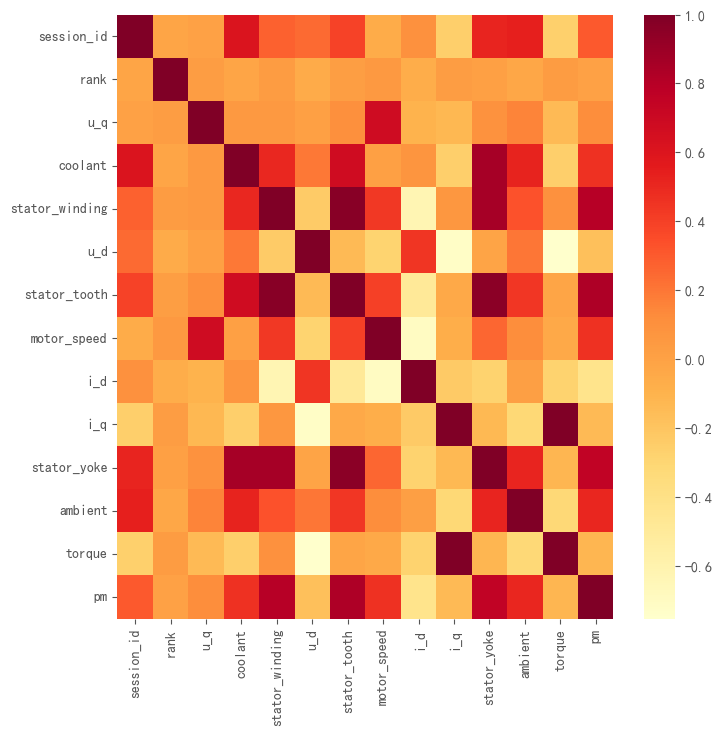

In [24]:
fig = plt.figure(1, figsize = (8,8),dpi=100)
corr = train.corr()
sns.heatmap(corr,cmap="YlOrRd")

#### *数据检验*

<AxesSubplot:xlabel='rank', ylabel='pm'>

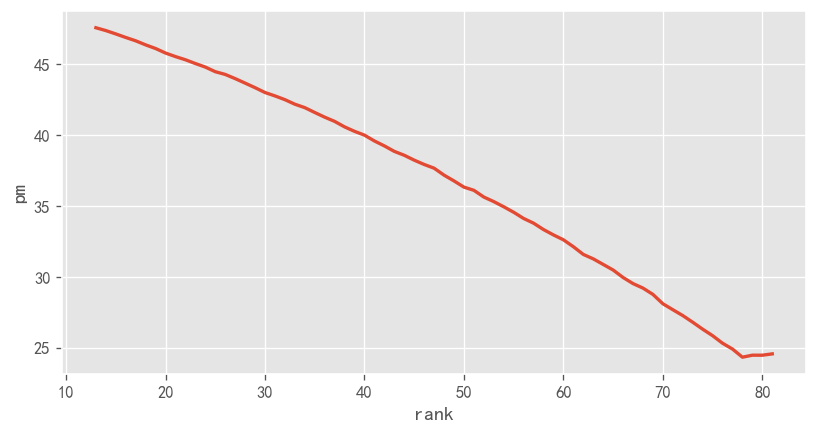

In [25]:
plt.figure(figsize=(8, 4),dpi=120,facecolor='white')
sns.lineplot(data=data[data['session_id']==0],x='rank',y='pm')

#### *差分ADF检验*

In [26]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
y=data[data['session_id'] ==2]['pm'][::-1]
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.788911
p-value: 0.822358


In [27]:
 
### Adf 检验
#ndiffs(y, test='adf')  # 2
# 
## KPSS 检验
#ndiffs(y, test='kpss')  # 0
# 
## PP 检验:
#ndiffs(y, test='pp')  # 2

#### *ACF,PACF检验*

In [28]:
import statsmodels.api as sm  # 统计相关的库
m = 10 # 我们检验10个自相关系数
y=data[data['session_id'] ==0]['pm'][::-1]
acf,q,p = sm.tsa.acf(y,nlags=m,qstat=True)  ## 计算自相关系数 及p-value
out = np.c_[range(1,11), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output

,AC,Q,P-value
lag,,,
1.0,0.961042,66.540079,3.428513e-16
2.0,0.920002,128.428612,1.294438e-28
3.0,0.877341,185.563347,5.545481e-40
4.0,0.832661,237.818731,2.736351e-50
5.0,0.788424,285.401233,1.375527e-59
6.0,0.744274,328.476938,6.417228e-68
7.0,0.700590,367.260118,2.481318e-75
8.0,0.657344,401.962836,7.123513e-82
9.0,0.614453,432.790028,1.366498e-87


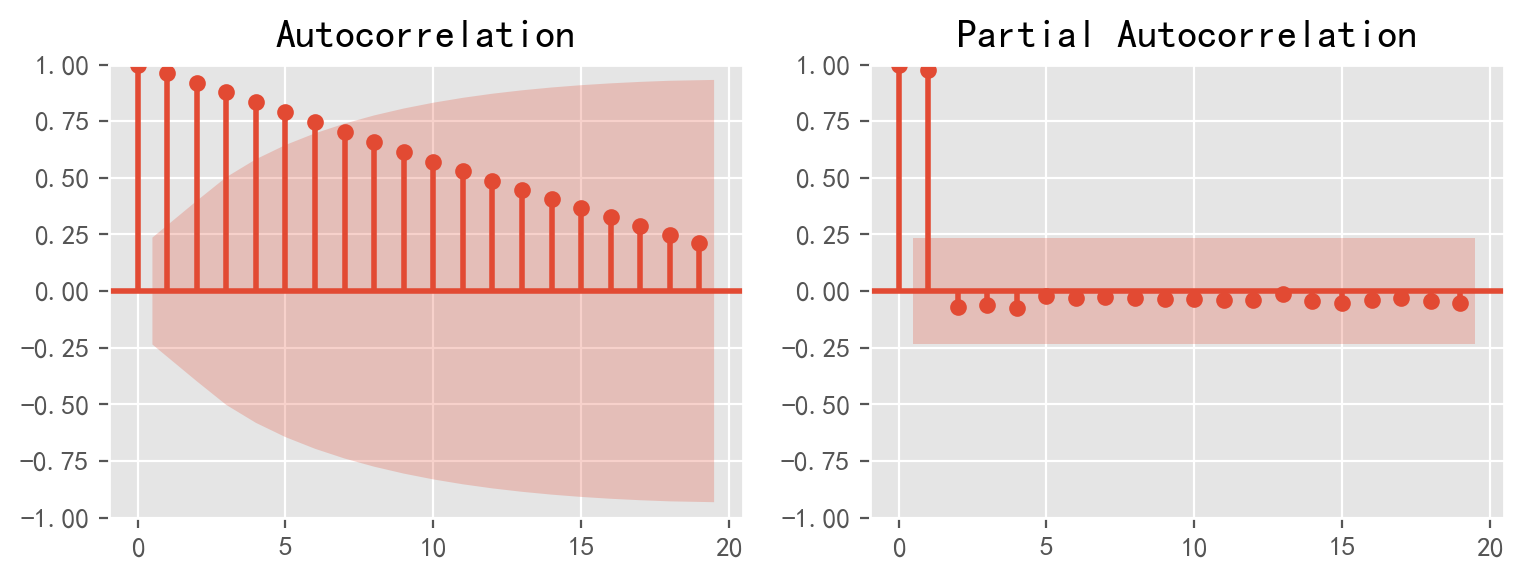

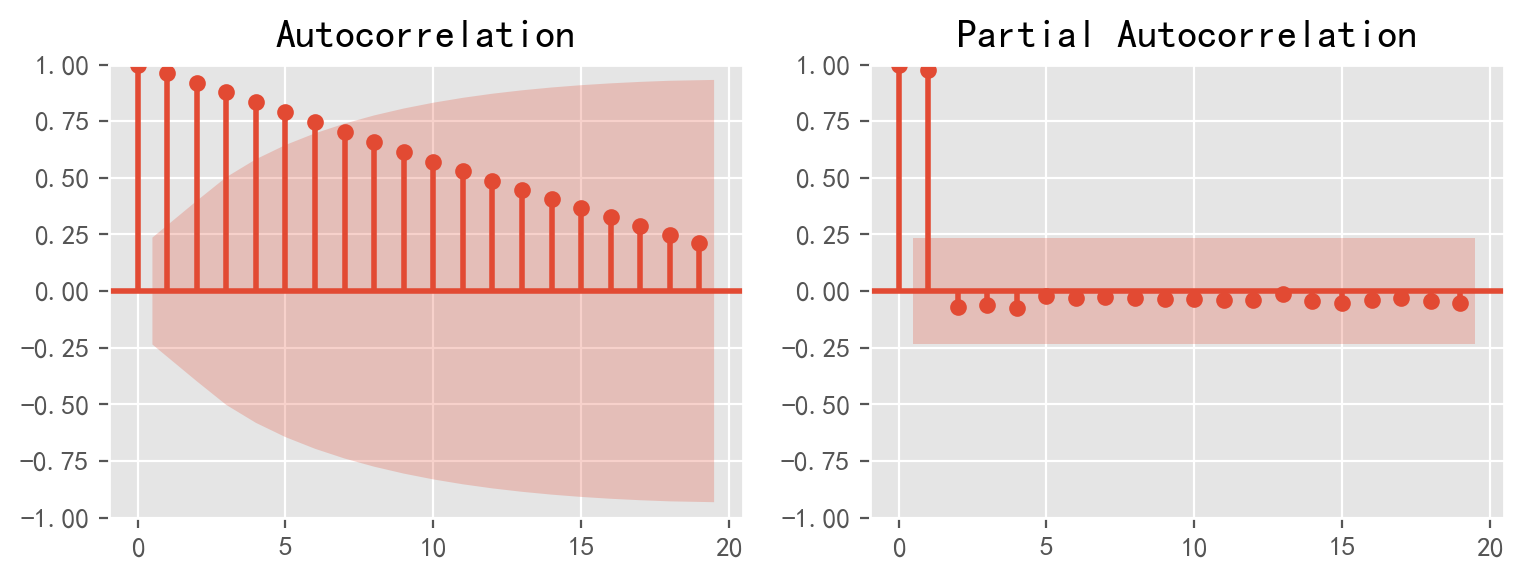

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
y=data[data['session_id'] ==0]['pm'][::-1]
plt.figure(figsize=(9, 3),dpi=200,facecolor='white')
ax1=plt.subplot(121)
plot_acf(y,ax=ax1)

ax2=plt.subplot(122)
plot_pacf(y,ax=ax2)


#### *aic,bic检验*  


In [30]:
"""
AIC=-2ln(L)+2k 中文名字：赤池信息量 akaike information criterion  
BIC=-2ln(L)+ln(n)*k 中文名字：贝叶斯信息量 bayesian information criterion  
HQ=-2ln(L)+ln(ln(n))*k hannan-quinn criterion  
我们常用的是AIC准则，AIC鼓励数据拟合的优良性但是尽量避免出现过度拟合(Overfitting)的情况。 
所以优先考虑的模型应是AIC值最小的那一个模型。
"""
sm.tsa.arma_order_select_ic(y,max_ar=6,max_ma=4,ic='aic')['aic_min_order']  # AIC

(2, 1)

In [31]:
sm.tsa.arma_order_select_ic(y,max_ar=6,max_ma=4,ic='bic')['bic_min_order']  # BIC

(2, 1)

In [32]:
sm.tsa.arma_order_select_ic(y,max_ar=6,max_ma=4,ic='hqic')['hqic_min_order'] # HQIC

(2, 1)

#### *Arima拟合优度*

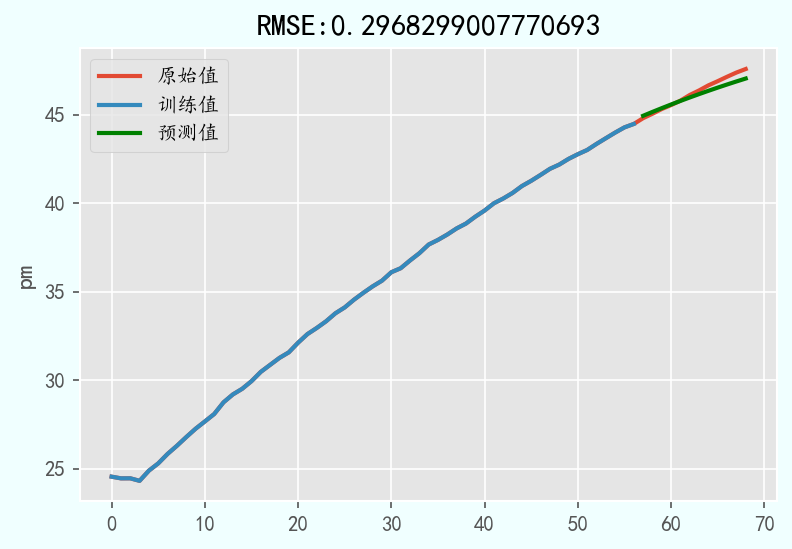

In [33]:
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error,r2_score
y=data[data['session_id'] ==0]['pm'][::-1]
train = y[:-12]
test = y[-12:]
ARIMA = ARIMA(endog=train, order=(2, 1, 1))
ARIMA_modle = ARIMA.fit()
y_pred = ARIMA_modle.predict(start=len(train)+1, end=len(train)+12)

rmse = np.sqrt(mean_squared_error(test, y_pred))
r2 = np.sqrt(r2_score(test, y_pred))

fig=plt.figure(figsize=(6,4),dpi=150,facecolor='#F0FFFF')
sns.lineplot(x=range(0,len(y)), y=y,label='原始值')
sns.lineplot(x=range(0,len(train)), y=train,label='训练值')
sns.lineplot(x=range(len(train),len(train)+12), y=y_pred,label='预测值',color='g')
plt.title(f"RMSE:{rmse}")
plt.legend();

In [34]:
RMSE : 0.1308
r2 : 0.9892

### ———建模———

#### *Arima预测*

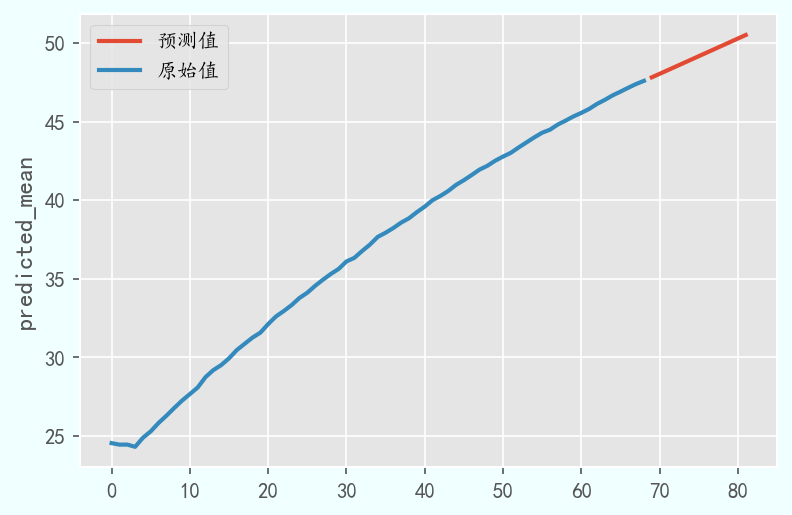

In [35]:
def ARIMA():    
    from statsmodels.tsa.arima.model import ARIMA 

    y=data[data['session_id'] ==0]['pm'][::-1]

    ARIMA = ARIMA(endog=y, order=(2, 2, 1))
    ARIMA_modle = ARIMA.fit()
    y_pred = ARIMA_modle.predict(start=len(y), end=len(y)+12)

    fig=plt.figure(figsize=(6,4),dpi=150,facecolor='#F0FFFF')
    sns.lineplot(x=range(len(y),len(y)+13), y=y_pred,label='预测值')
    sns.lineplot(x=range(0,len(y)), y=y,label='原始值')
    plt.legend();
ARIMA()

#### *指数平滑法*

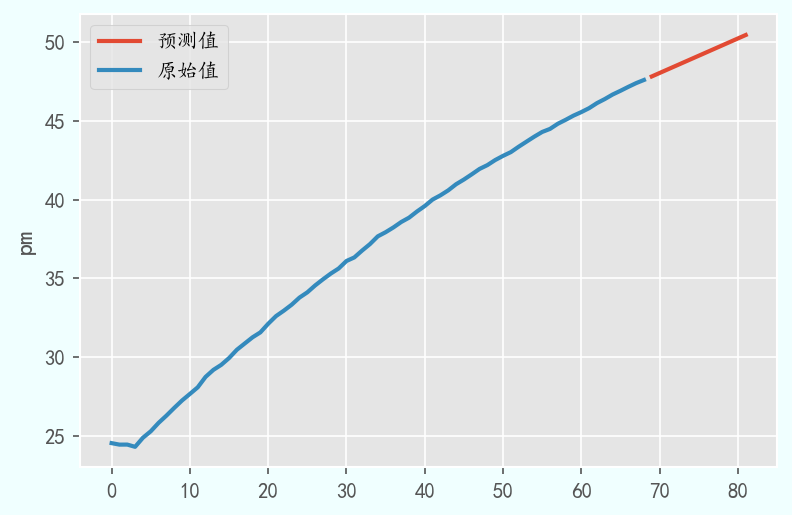

In [36]:
def Holt_pred():    
    from statsmodels.tsa.holtwinters import Holt
    y=data[data['session_id'] ==0]['pm'][::-1]
    Holt = Holt(endog=y, initialization_method='estimated')
    Holt_model = Holt.fit()
    y_pred = Holt_model.predict(start=len(y), end=len(y)+12)
    fig=plt.figure(111,figsize=(6,4),dpi=150,facecolor='#F0FFFF')
    sns.lineplot(x=range(len(y),len(y)+13), y=y_pred,label='预测值')
    sns.lineplot(x=range(0,len(y)), y=y,label='原始值')
    plt.legend();
Holt_pred()

In [ ]:
def rolling_forecast_Holt(k=0,rolling_size=50,test_size=12,ps=1):
    """
    k:会话测试数据
    roling_size:滚动窗口的大小
    test_size:需要预测的个数,默认25
    ps:每次预测的个数,默认1
    """
    # 设置滚动预测的参数
    
    y_read=data[data['session_id'] ==k]['pm'][::-1]
    y=data[data['session_id'] ==k]['pm'][::-1]
    pre = []  # 存放预测值

    # 滚动预测
    for i in range(test_size):
        from statsmodels.tsa.holtwinters import Holt
        y=y.append(pd.Series(pre).tail(1))
        train = y[-(rolling_size):]
        Holt = Holt(endog=train,initialization_method='estimated')
        Holt_model = Holt.fit()
        y_pred = Holt_model.predict(start=len(train), end=len(train)+1)
        pre.append(y_pred[-1])
        print(f'预测第{i+1}个值为{pre[-1:]}')

    # 画图
    fig=plt.figure(111,figsize=(6,4),dpi=100,facecolor='white')
    sns.lineplot(x=range(0,len(y_read)), y=y_read,color='b',label='原始值')
    sns.lineplot(x=range(len(y_read),len(y_read)+test_size), y=pre,color='r',label='预测值')
    plt.legend();
rolling_forecast_Holt(0,25)

In [49]:
def Holt_forecast():
    from datetime import datetime
    time_start=datetime.now()
    for i in range(len(data['session_id'].unique()-1)):
        from statsmodels.tsa.holtwinters import Holt
        y=data[data['session_id'] ==i]['pm'][::-1]
        Holt = Holt(endog=y, initialization_method='estimated')
        Holt_model = Holt.fit()
        y_pred = Holt_model.predict(start=len(y), end=len(y)+12)
        y_pred = y_pred[::-1]
        sample_submit.loc[sample_submit['session_id']==i, 'pm'] = y_pred
        print(f"写入第{i}个会话数据!")
    sample_submit.to_csv('holt.csv', index=False)
    time_end=datetime.now()
    print(f"模型预测完成！！！！！")
    print(f"计算用时：{((time_end-time_start).seconds)//60}分钟")

写入第0个会话数据!
写入第1个会话数据!
写入第2个会话数据!
写入第3个会话数据!
写入第4个会话数据!
写入第5个会话数据!
写入第6个会话数据!
写入第7个会话数据!
写入第8个会话数据!
写入第9个会话数据!
写入第10个会话数据!
写入第11个会话数据!
写入第12个会话数据!
写入第13个会话数据!
写入第14个会话数据!
写入第15个会话数据!
写入第16个会话数据!
写入第17个会话数据!
写入第18个会话数据!
写入第19个会话数据!
写入第20个会话数据!
写入第21个会话数据!
写入第22个会话数据!
写入第23个会话数据!
写入第24个会话数据!
写入第25个会话数据!
写入第26个会话数据!
写入第27个会话数据!
写入第28个会话数据!
写入第29个会话数据!
写入第30个会话数据!
写入第31个会话数据!
写入第32个会话数据!
写入第33个会话数据!
写入第34个会话数据!
写入第35个会话数据!
写入第36个会话数据!
写入第37个会话数据!
写入第38个会话数据!
写入第39个会话数据!
写入第40个会话数据!
写入第41个会话数据!
写入第42个会话数据!
写入第43个会话数据!
写入第44个会话数据!
写入第45个会话数据!
写入第46个会话数据!
写入第47个会话数据!
写入第48个会话数据!
写入第49个会话数据!
写入第50个会话数据!
写入第51个会话数据!
写入第52个会话数据!
写入第53个会话数据!
写入第54个会话数据!
写入第55个会话数据!
写入第56个会话数据!
写入第57个会话数据!
写入第58个会话数据!
写入第59个会话数据!
写入第60个会话数据!
写入第61个会话数据!
写入第62个会话数据!
写入第63个会话数据!
写入第64个会话数据!
写入第65个会话数据!
写入第66个会话数据!
写入第67个会话数据!
写入第68个会话数据!
写入第69个会话数据!
写入第70个会话数据!
写入第71个会话数据!
写入第72个会话数据!
写入第73个会话数据!
写入第74个会话数据!
写入第75个会话数据!
写入第76个会话数据!
写入第77个会话数据!
写入第78个会话数据!
写入第79个会话数据!
写入第80个会话数据!
写入第81个会话数据!
写入第82个会话数据!
写入第83个会话数据!
写入

In [10]:
y=data[data['session_id'] ==0]['pm'][::-1]
y

68    24.554696
67    24.460167
66    24.462605
65    24.320442
64    24.896908
        ...    
4     46.661446
3     46.897395
2     47.146833
1     47.383591
0     47.584192
Name: pm, Length: 69, dtype: float64

In [ ]:
from datetime import datetime
time_start=datetime.now()
from statsmodels.tsa.holtwinters import Holt
y=data[data['session_id'] ==0]['pm'][::-1]

y=data[data['session_id'] ==0]['pm'][::-1]
#print(y)
Holt = Holt(endog=y, initialization_method='estimated')
Holt_model = Holt.fit()
y_pred = Holt_model.predict(start=len(y), end=len(y)+12)
y_pred = y_pred[::-1]


In [18]:
print(y_pred)


81    50.435247
80    50.216270
79    49.997293
78    49.778315
77    49.559338
76    49.340360
75    49.121383
74    48.902405
73    48.683428
72    48.464450
71    48.245473
70    48.026495
69    47.807518
dtype: float64


In [20]:
sample_submit.loc[sample_submit['session_id']==0,'pm'] = y_pred
sample_submit.to_csv('holt.csv', index=False)

In [ ]:
print(f"写入第{0}个会话数据!")

time_end=datetime.now()
print(f"模型预测完成！！！！！")
print(f"计算用时：{((time_end-time_start).seconds)//60}分钟")

#### *平均增长率*

In [ ]:
# 读取训练数据和测试数据
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submit = pd.read_csv('sample_submit.csv')

for i in range(0,12):
    rk = 12 - i
    # 平均增长率计算
    ratio = 0
    for j in range(1,25):
        ratio += train[train['rank']==rk+j]['pm'].values / train[train['rank']==rk+j+1]['pm'].values
    ratio /= j
    
    # 当前rank结果 * 平均增长率 = 下个rank的结果
    res = train[train['rank']==rk+1]['pm'].values * ratio
    
    # 将当前计算的rank结果拼接到训练数据，便于计算接下来的rank结果
    train = train.append(pd.DataFrame({'pm':res,'rank':[rk]*test['session_id'].nunique()}))
    
    # 保存对于rank的pm
    sample_submit.loc[sample_submit['rank']==rk, 'pm'] = train.loc[train['rank']==rk, 'pm'].values

In [ ]:
sample_submit.to_csv('平均增长率.csv', index=False)

#### *Prophet*

In [6]:
from prophet import Prophet
y=data[data['session_id'] ==0]['pm'][::-1]
x=data[data['session_id'] ==0]['rank'][::-1]
model = Prophet().fit(y)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

#### *Auto_Arima-多步预测-验证*

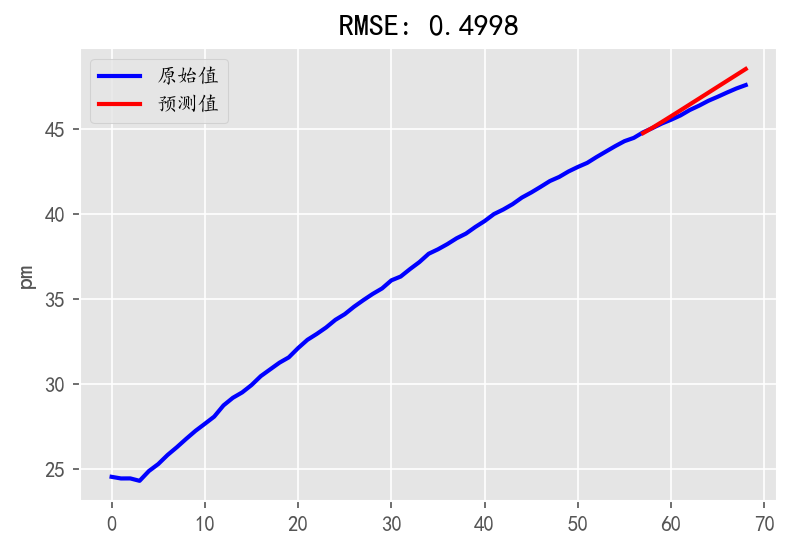

In [ ]:
def Auto_Arima():
    """
    start_p:p的起始值，自回归(“AR”)模型的阶数(或滞后时间的数量),必须是正整数
    start_q:q的初始值，移动平均(MA)模型的阶数。必须是正整数。
    max_p:p的最大值，必须是大于或等于start_p的正整数。
    max_q:q的最大值，必须是一个大于start_q的正整数
    seasonal:是否适合季节性ARIMA。默认是正确的。注意，如果season为真，而m == 1，则season将设置为False。
    stationary :时间序列是否平稳，d是否为零。
    information_criterion：信息准则用于选择最佳的ARIMA模型。(‘aic’，‘bic’，‘hqic’，‘oob’)之一
    alpha：检验水平的检验显著性，默认0.05
    test:如果stationary为假且d为None，用来检测平稳性的单位根检验的类型。默认为‘kpss’;可设置为adf
    n_jobs ：网格搜索中并行拟合的模型数(逐步=False)。默认值是1，但是-1可以用来表示“尽可能多”。
    suppress_warnings：statsmodel中可能会抛出许多警告。如果suppress_warnings为真，那么来自ARIMA的所有警告都将被压制
    error_action:如果由于某种原因无法匹配ARIMA，则可以控制错误处理行为。(warn,raise,ignore,trace)
    max_d:d的最大值，即非季节差异的最大数量。必须是大于或等于d的正整数。
    trace:是否打印适合的状态。如果值为False，则不会打印任何调试信息。值为真会打印一些
    """    
    from pmdarima.arima import auto_arima
    k=0
    y=data[data['session_id'] ==k]['pm'][::-1]
    train = y[:-12]
    test = y[-12:]
    model = auto_arima(train, 
                        start_p=1, start_q=1, 
                        max_p=9, max_q=6, max_d=3,
                        mseasonal=False, m=1, #不考虑季节性。
                        test='adf', 
                        trace=False,
                        seasonal=False,        
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True,
                        information_criterion='bic',
                        njob=-1)
    #print(model.summary())

    y_pred = model.predict(12)
    rmse = np.sqrt(mean_squared_error(test, y_pred))
    
    fig=plt.figure(111,figsize=(6,4),dpi=150,facecolor='white')
    sns.lineplot(x=range(0,len(y)), y=y,color='b',label='原始值')
    sns.lineplot(x=range(len(y)-12,len(y)),color='r', y=y_pred,label='预测值')
    plt.title('RMSE: %.4f'%rmse)
    plt.legend();
Auto_Arima()

#### *Auto_Arima-滚动预测-验证*

预测第1个值为[44.2873710051902]
预测第2个值为[44.480589793588216]
预测第3个值为[44.807210915720816]
预测第4个值为[45.05649260717625]
预测第5个值为[45.32368438670237]
预测第6个值为[45.54733243503514]
预测第7个值为[45.79808940469293]
预测第8个值为[46.11737668982192]
预测第9个值为[46.37391313479683]
预测第10个值为[46.66144570692438]
预测第11个值为[46.89739512688566]
预测第12个值为[47.14683257769573]


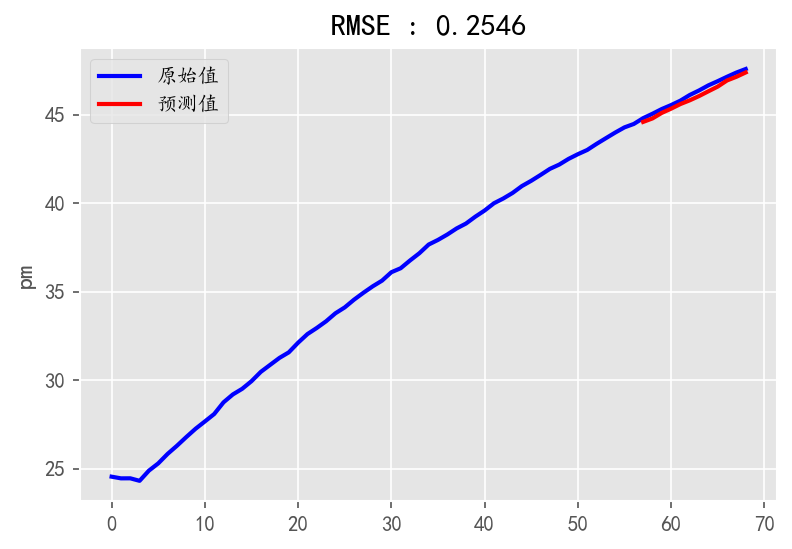

In [ ]:
# 设置滚动预测的参数
from pmdarima.arima import auto_arima
k=0
y=data[data['session_id'] ==k]['pm'][::-1]
test_size = 12  # 需要预测的个数
rolling_size = 25  # 滚动窗口大小
ps = 1  # 每次预测的个数
horizon = 1  # 用来消除切片的影响
pre = []  # 存放预测值
test =y[-test_size:]

# 滚动预测
for i in range(test_size):
    train =y[-(rolling_size + test_size - i):-(test_size + horizon - i)]
    print(f'预测第{i+1}个值为{train[-1:].tolist()}')
    model = auto_arima(train, start_p=0, start_q=0, max_p=6, max_q=6, max_d=2,
                        seasonal=True, test='adf',
                        error_action='ignore',
                        information_criterion='aic',
                        n_job=-1, suppress_warnings=True)
    model.fit(train)
    forecast = model.predict(n_periods=ps)
    pre.append(forecast[-1])

predictions_ = pd.Series(pre,index=test.index)

# 计算RMSE
rmse = np.sqrt(mean_squared_error(test,predictions_))

# 画图
fig=plt.figure(111,figsize=(6,4),dpi=150,facecolor='white')
sns.lineplot(x=range(0,len(y)), y=y,color='b',label='原始值')
sns.lineplot(x=range(len(y)-12,len(y)), y=pre,color='r',label='预测值')
plt.title('RMSE : %.4f' % rmse)
plt.legend();

#### *Auto_Arima-多步预测*

In [22]:
from datetime import datetime
from tabnanny import verbose
time_start=datetime.now()
from pmdarima.arima import auto_arima

for k in range(0,len(data['session_id'].unique()-1)):

    y=data[data['session_id'] ==k]['pm'][::-1]
    model = auto_arima(y, start_p=0, start_q=0
                            ,max_p=20, max_q=20, max_d=5
                            ,mseasonal=False, m=1 #不考虑季节性。
                            ,test='adf' 
                            ,trace=False
                            ,seasonal=False  
                            ,maxiter=50   
                            ,method='nm'
                            ,error_action='ignore'
                            ,suppress_warnings=True
                            ,stepwise=True
                            ,information_criterion='bic'
                            ,n_job=-1
                            ,scoring='mse'
                            )
    y_pred = model.predict(12)
    sample_submit.loc[sample_submit['session_id']==k, 'pm'] = y_pred[::-1]
    print(f"写入第{k}个会话数据!")
    time_end1=datetime.now()
sample_submit.to_csv('auto_arima_1.csv', index=False)
time_end=datetime.now()
print(f"模型预测完成！！！！！")
print(f"计算用时：{((time_end-time_start).seconds)//60}分钟")

写入第0个会话数据!
写入第1个会话数据!
写入第2个会话数据!
写入第3个会话数据!
写入第4个会话数据!
写入第5个会话数据!
写入第6个会话数据!
写入第7个会话数据!
写入第8个会话数据!
写入第9个会话数据!
写入第10个会话数据!
写入第11个会话数据!
写入第12个会话数据!
写入第13个会话数据!
写入第14个会话数据!
写入第15个会话数据!
写入第16个会话数据!
写入第17个会话数据!
写入第18个会话数据!
写入第19个会话数据!
写入第20个会话数据!
写入第21个会话数据!
写入第22个会话数据!
写入第23个会话数据!
写入第24个会话数据!
写入第25个会话数据!
写入第26个会话数据!
写入第27个会话数据!
写入第28个会话数据!
写入第29个会话数据!
写入第30个会话数据!
写入第31个会话数据!
写入第32个会话数据!
写入第33个会话数据!
写入第34个会话数据!
写入第35个会话数据!
写入第36个会话数据!
写入第37个会话数据!
写入第38个会话数据!
写入第39个会话数据!
写入第40个会话数据!
写入第41个会话数据!
写入第42个会话数据!
写入第43个会话数据!
写入第44个会话数据!
写入第45个会话数据!
写入第46个会话数据!
写入第47个会话数据!
写入第48个会话数据!
写入第49个会话数据!
写入第50个会话数据!
写入第51个会话数据!
写入第52个会话数据!
写入第53个会话数据!
写入第54个会话数据!
写入第55个会话数据!
写入第56个会话数据!
写入第57个会话数据!
写入第58个会话数据!
写入第59个会话数据!
写入第60个会话数据!
写入第61个会话数据!
写入第62个会话数据!
写入第63个会话数据!
写入第64个会话数据!
写入第65个会话数据!
写入第66个会话数据!
写入第67个会话数据!
写入第68个会话数据!
写入第69个会话数据!
写入第70个会话数据!
写入第71个会话数据!
写入第72个会话数据!
写入第73个会话数据!
写入第74个会话数据!
写入第75个会话数据!
写入第76个会话数据!
写入第77个会话数据!
写入第78个会话数据!
写入第79个会话数据!
写入第80个会话数据!
写入第81个会话数据!
写入第82个会话数据!
写入第83个会话数据!
写入

In [ ]:
0.26483

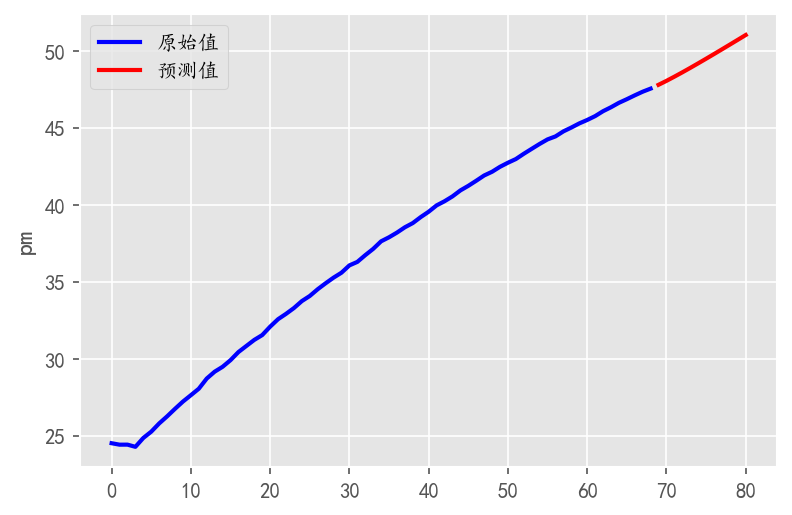

In [30]:
from turtle import color
def Auto_Arima():
    from pmdarima.arima import auto_arima
    k=0
    y=data[data['session_id'] ==k]['pm'][::-1]
    model = auto_arima(y, 
                        start_p=0, start_q=0, 
                        max_p=9, max_q=6, max_d=3,
                        mseasonal=False, m=1, #不考虑季节性。
                        test='adf', 
                        trace=False,
                        seasonal=False,        
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True,
                        information_criterion='bic',
                        njob=-1)
    #print(model.summary())

    y_pred = model.predict(12)
    #rmse = np.sqrt(mean_squared_error(test, y_pred))
    
    fig=plt.figure(111,figsize=(6,4),dpi=150,facecolor='white')
    sns.lineplot(x=range(0,len(y)), y=y,color='b',label='原始值')
    sns.lineplot(x=range(len(y),len(y)+12),color='r', y=y_pred,label='预测值')
    #plt.title('RMSE: %.4f'%rmse)
    plt.legend();
Auto_Arima()

#### *Auto_Arima-滚动预测*

In [31]:
aList=[3,4,5,6,7,9,11,13,15,17]
print(aList[::])  #[3, 4, 5, 6, 7, 9, 11, 13, 15, 17]
print(aList[::-1])  #[17, 15, 13, 11, 9, 7, 6, 5, 4, 3]
#加了负号，就是一个逆向输出
print(aList[::2])  # [3, 5, 7, 11, 15]
#以步长为2进行输出，输出下标依次为0 2 4 6
print(aList[1::2])  #[4, 6, 9, 13, 17],从一开始步长为2
print(aList[3::])  #[6, 7, 9, 11, 13, 15, 17]
print(aList[3:6])  #省略的是步长，而且不包括下标为6的元素   #[6, 7, 9]
print(aList[-3:])

[3, 4, 5, 6, 7, 9, 11, 13, 15, 17]
[17, 15, 13, 11, 9, 7, 6, 5, 4, 3]
[3, 5, 7, 11, 15]
[4, 6, 9, 13, 17]
[6, 7, 9, 11, 13, 15, 17]
[6, 7, 9]
[13, 15, 17]


预测第1个值为[47.821336219240294]
预测第2个值为[48.032346127249745]
预测第3个值为[48.24301859318953]
预测第4个值为[48.46612613033259]
预测第5个值为[48.72785316580801]
预测第6个值为[48.99278898159973]
预测第7个值为[49.209071077143165]
预测第8个值为[49.42002647584422]
预测第9个值为[49.631881159208504]
预测第10个值为[49.83694447913506]
预测第11个值为[50.04312858881486]
预测第12个值为[50.2447374680119]


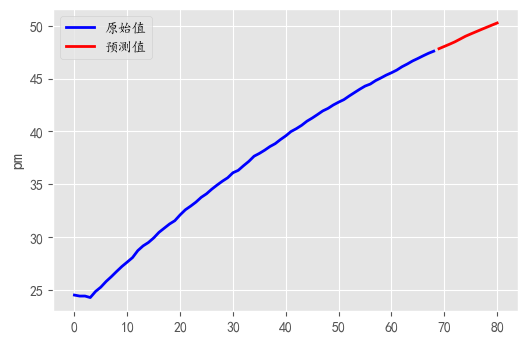

In [102]:
def rolling_forecast_auto_arima(k,rolling_size,test_size=12,ps=1):
    """
    k:会话测试数据
    roling_size:滚动窗口的大小
    test_size:需要预测的个数,默认25
    ps:每次预测的个数,默认1
    """
    # 设置滚动预测的参数
    y_read=data[data['session_id'] ==k]['pm'][::-1]
    y=data[data['session_id'] ==k]['pm'][::-1]
    #rolling_size = 30  # 滚动窗口大小
    #ps = 1  # 每次预测的个数
    #horizon = 1  # 用来消除切片的影响
    pre = []  # 存放预测值

    # 滚动预测
    for i in range(test_size//ps):
        #train =y[-(rolling_size - i):-(horizon - i)]
        #train =y[-(rolling_size + test_size - i):-(test_size + horizon - i)]
        y=y.append(pd.Series(pre).tail(1))
        train = y[-(rolling_size):]
        model = auto_arima(train, start_p=0, start_q=0
                                ,max_p=10, max_q=10, max_d=3
                                ,mseasonal=False, m=1 #不考虑季节性。
                                ,test='adf' 
                                ,trace=False
                                ,seasonal=False  
                                ,maxiter=50   
                                ,method='nm'
                                ,error_action='ignore'
                                ,suppress_warnings=True
                                ,stepwise=True
                                ,information_criterion='bic'
                                ,n_job=-1
                                ,scoring='mse'
                                ,random_state=2022)
                            
        y_pred = model.predict(ps)
        pre.append(y_pred[-ps])
        print(f'预测第{i+1}个值为{pre[-ps:]}')

    # 画图
    fig=plt.figure(111,figsize=(6,4),dpi=100,facecolor='white')
    sns.lineplot(x=range(0,len(y_read)), y=y_read,color='b',label='原始值')
    sns.lineplot(x=range(len(y_read),len(y_read)+test_size), y=pre,color='r',label='预测值')
    #plt.title('RMSE : %.4f' % rmse)
    plt.legend();
rolling_forecast_auto_arima(0,25)

In [ ]:
from datetime import datetime
time_start=datetime.now()
from pmdarima.arima import auto_arima
for k in range(0,len(data['session_id'].unique()-1)):

    y=data[data['session_id'] ==k]['pm'][::-1]
    test_size = 12  # 需要预测的个数
    rolling_size = 25  # 滚动窗口大小
    ps = 1  # 每次预测的个数
    horizon = 1  # 用来消除切片的影响
    pre = []  # 存放预测值

    # 滚动预测
    for i in range(test_size):
        #print(f'预测第{i+1}个值为{y.tail(1)}')
        #train =y[-(rolling_size + test_size - i):-(test_size + horizon - i)]
        #pre=pre
        y=y.append(pd.Series(pre).tail(1))
        train = y[-(rolling_size):]
        model = auto_arima(train, start_p=0, start_q=0 
                                ,max_p=10, max_q=10, max_d=3
                                ,mseasonal=False, m=1 #不考虑季节性。
                                ,test='adf' 
                                ,trace=False
                                ,seasonal=False  
                                ,maxiter=50   
                                ,method='nm'
                                ,error_action='ignore'
                                ,suppress_warnings=True
                                ,stepwise=True
                                ,information_criterion='bic'
                                ,n_job=-1
                                ,scoring='rmse'
                                ,random_state=2022)
                            
        y_pred = model.predict(ps)
        pre.append(y_pred[-1])
    y_pred = pre[::-1]
    sample_submit.loc[sample_submit['session_id']==k, 'pm'] = y_pred
    print(f"写入第{k}个会话数据!!!")
sample_submit.to_csv('auto_arima_滚动预测.csv', index=False)
time_end=datetime.now()
print(f"模型预测完成！！！！！")
print(f"计算用时：{((time_end-time_start).seconds)/60}分钟")

写入第0个会话数据
写入第1个会话数据
写入第2个会话数据
写入第3个会话数据
写入第4个会话数据
写入第5个会话数据
写入第6个会话数据
写入第7个会话数据
写入第8个会话数据
写入第9个会话数据
写入第10个会话数据
写入第11个会话数据
写入第12个会话数据
写入第13个会话数据
写入第14个会话数据
写入第15个会话数据
写入第16个会话数据
写入第17个会话数据
写入第18个会话数据
写入第19个会话数据
写入第20个会话数据
写入第21个会话数据
写入第22个会话数据
写入第23个会话数据
写入第24个会话数据
写入第25个会话数据
写入第26个会话数据
写入第27个会话数据
写入第28个会话数据
写入第29个会话数据
写入第30个会话数据
写入第31个会话数据
写入第32个会话数据
写入第33个会话数据
写入第34个会话数据
写入第35个会话数据
写入第36个会话数据
写入第37个会话数据
写入第38个会话数据
写入第39个会话数据
写入第40个会话数据
写入第41个会话数据
写入第42个会话数据
写入第43个会话数据
写入第44个会话数据
写入第45个会话数据
写入第46个会话数据
写入第47个会话数据
写入第48个会话数据
写入第49个会话数据
写入第50个会话数据
写入第51个会话数据
写入第52个会话数据
写入第53个会话数据
写入第54个会话数据
写入第55个会话数据
写入第56个会话数据
写入第57个会话数据
写入第58个会话数据
写入第59个会话数据
写入第60个会话数据
写入第61个会话数据
写入第62个会话数据
写入第63个会话数据
写入第64个会话数据
写入第65个会话数据
写入第66个会话数据
写入第67个会话数据
写入第68个会话数据
写入第69个会话数据
写入第70个会话数据
写入第71个会话数据
写入第72个会话数据
写入第73个会话数据
写入第74个会话数据
写入第75个会话数据
写入第76个会话数据
写入第77个会话数据
写入第78个会话数据
写入第79个会话数据
写入第80个会话数据
写入第81个会话数据
写入第82个会话数据
写入第83个会话数据
写入第84个会话数据
写入第85个会话数据
写入第86个会话数据
写入第87个会话数据
写入第88个会话数据
写入第89个会话数据
写入第90个会话数据
写入第91个会话数